In [1]:
# Prepare demo environment

export TERM=ansi
eval `dircolors`
GIT=`which git`
declare -A git_helped=()
git() {
    if [[ $1 != -* && -z ${git_helped[$1]} ]] ; then
        echo -ne '\e[48;5;195m' >&2
        whatis -l "git-$1" | sed 's/ (1)//' >&2
        echo -ne '\e[0m' >&2
        git_helped[$1]=1
    fi
    if [[ $1 = merge || $1 = revert ]] ; then
        set -- "$@" --no-edit
    fi
    $GIT "$@"
}

rm -rf ~/myrepo

export GIT_AUTHOR_NAME="Dylan Simon" EMAIL="dylan-gst@dylex.net"
export GIT_COMMITTER_NAME=$GIT_AUTHOR_NAME GIT_PAGER=cat

<div align='center'>
<h1>The Structure of Git</h1>
<h2>A git tutorial for (computer) scientists</h2>
<h3>Dylan Simon, Flatiron Institute</h3>
<br>
[github.com/dylex/git-structure-tutorial](https://github.com/dylex/git-structure-tutorial)
</div>

First, try to forget anything you know about other revision control systems, and even git itself.  In fact, for the moment, let's forget about revision control.

Second, this is a workshop: follow along, try things yourself, ask questions.

<div align='center'>
<h1>Part 1: Data Structures</h1>
<h2>(Commands you'll never use again)</h2>
</div>

Git has lots of functionality, often based on other revision control systems, but at its core it's quite simple.  Even though you will rarely use these core commands, it's useful to understand how they work, and thus how all the more complicated interfaces are just constructed out of these simpler ones. Also, if you get confused about what's going on, this will give you enough to get by on first principles.

## git repository environment

Create a new repository in any existing directory

In [2]:
git init ~/myrepo
cd ~/myrepo

git-init         - Create an empty Git repository or reinitialize an existing one
Initialized empty Git repository in /home/dylan/myrepo/.git/


You can turn any directory into a git repository.  You'll more often create a new one based on an existing repository using clone, as we'll see at the end.  For now, we'll just start with an empty directory.

In [3]:
ls .git

HEAD  config  description  hooks  info  objects  refs


All this does is create a .git directory with some stuff in it.  Normally you won't touch any of this stuff directly, but we'll see what some of it does.  You can also have a .git directory by itself, which is called a "bare" repository and is like a backend or server only: only usable "remotely".

In [4]:
cat .git/config

[core]
	repositoryformatversion = 0
	filemode = true
	bare = false
	logallrefupdates = true


One of the files in this directory you might look at is config.  Git config files are simple ini-type files.  There is also your "global" config in `~/.gitconfig`.

In [5]:
git config --local -l

git-config       - Get and set repository or global options
core.repositoryformatversion=0
core.filemode=true
core.bare=false
core.logallrefupdates=true


However, there is also a git command that lets you manipulate config files, so you don't have to edit them yourself.

In [6]:
git config -h
git help config
git help

usage: git config [<options>]

Config file location
    --global              use global config file
    --system              use system config file
    --local               use repository config file
    -f, --file <file>     use given config file
    --blob <blob-id>      read config from given blob object

Action
    --get                 get value: name [value-regex]
    --get-all             get all values: key [value-regex]
    --get-regexp          get values for regexp: name-regex [value-regex]
    --get-urlmatch        get value specific for the URL: section[.var] URL
    --replace-all         replace all matching variables: name value [value_regex]
    --add                 add a new variable: name value
    --unset               remove a variable: name [value-regex]
    --unset-all           remove all matches: name [value-regex]
    --rename-section      rename section: old-name new-name
    --remove-section      remove a section: name
    -l, --list            list all
 

           spell blob names.

       --remove-section
           Remove the given section from the configuration file.

       --rename-section
           Rename the given section to a new name.

       --unset
           Remove the line matching the key from config file.

       --unset-all
           Remove all lines matching the key from config file.

       -l, --list
           List all variables set in config file, along with their values.

       --bool
           git config will ensure that the output is "true" or "false"

       --int
           git config will ensure that the output is a simple decimal number.
           An optional value suffix of k, m, or g in the config file will
           cause the value to be multiplied by 1024, 1048576, or 1073741824
           prior to output.

       --bool-or-int
           git config will ensure that the output matches the format of either
           --bool or --int, as described above.

       --path
           git-config will exp


           % git config section.key value '[!]'

       To add a new proxy, without altering any of the existing ones, use

           % git config --add core.gitproxy '"proxy-command" for example.com'

       An example to use customized color from the configuration in your
       script:

           #!/bin/sh
           WS=$(git config --get-color color.diff.whitespace "blue reverse")
           RESET=$(git config --get-color "" "reset")
           echo "${WS}your whitespace color or blue reverse${RESET}"

       For URLs in https://weak.example.com, http.sslVerify is set to false,
       while it is set to true for all others:

           % git config --bool --get-urlmatch http.sslverify https://good.example.com
           true
           % git config --bool --get-urlmatch http.sslverify https://weak.example.com
           false
           % git config --get-urlmatch http https://weak.example.com
           http.cookieFile /tmp/cookie.txt
           http.sslverify false

CONFIGURAT

                   renames = true

           [branch "devel"]
                   remote = origin
                   merge = refs/heads/devel

           # Proxy settings
           [core]
                   gitProxy="ssh" for "kernel.org"
                   gitProxy=default-proxy ; for the rest

           [include]
                   path = /path/to/foo.inc ; include by absolute path
                   path = foo.inc ; find "foo.inc" relative to the current file
                   path = ~/foo.inc ; find "foo.inc" in your `$HOME` directory

           ; include if $GIT_DIR is /path/to/foo/.git
           [includeIf "gitdir:/path/to/foo/.git"]
                   path = /path/to/foo.inc

           ; include for all repositories inside /path/to/group
           [includeIf "gitdir:/path/to/group/"]
                   path = /path/to/foo.inc

           ; include for all repositories inside $HOME/to/group
           [includeIf "gitdir:~/to/group/"]
                   path = /path/to/foo.

           with executable bit on.  git-clone(1) or git-init(1) probe the
           filesystem to see if it handles the executable bit correctly and
           this variable is automatically set as necessary.

           A repository, however, may be on a filesystem that handles the
           filemode correctly, and this variable is set to true when created,
           but later may be made accessible from another environment that
           loses the filemode (e.g. exporting ext4 via CIFS mount, visiting a
           Cygwin created repository with Git for Windows or Eclipse). In such
           a case it may be necessary to set this variable to false. See git-
           update-index(1).

           The default is true (when core.filemode is not specified in the
           config file).

       core.hideDotFiles
           (Windows-only) If true, mark newly-created directories and files
           whose name starts with a dot as hidden. If dotGitOnly, only the
           .git/ direc

           be set to input, in which case no output conversion is performed.

       core.symlinks
           If false, symbolic links are checked out as small plain files that
           contain the link text.  git-update-index(1) and git-add(1) will not
           change the recorded type to regular file. Useful on filesystems
           like FAT that do not support symbolic links.

           The default is true, except git-clone(1) or git-init(1) will probe
           and set core.symlinks false if appropriate when the repository is
           created.

       core.gitProxy
           A "proxy command" to execute (as command host port) instead of
           establishing direct connection to the remote server when using the
           Git protocol for fetching. If the variable value is in the "COMMAND
           for DOMAIN" format, the command is applied only on hostnames ending
           with the specified domain string. This variable may be set multiple
           times and is ma

           performance when accessing a large number of large pack files.

           Default is 1 MiB if NO_MMAP was set at compile time, otherwise 32
           MiB on 32 bit platforms and 1 GiB on 64 bit platforms. This should
           be reasonable for all users/operating systems. You probably do not
           need to adjust this value.

           Common unit suffixes of k, m, or g are supported.

       core.packedGitLimit
           Maximum number of bytes to map simultaneously into memory from pack
           files. If Git needs to access more than this many bytes at once to
           complete an operation it will unmap existing regions to reclaim
           virtual address space within the process.

           Default is 256 MiB on 32 bit platforms and 8 GiB on 64 bit
           platforms. This should be reasonable for all users/operating
           systems, except on the largest projects. You probably do not need
           to adjust this value.

           Common unit su

               of the line as an error (not enabled by default).

           ·   blank-at-eof treats blank lines added at the end of file as an
               error (enabled by default).

           ·   trailing-space is a short-hand to cover both blank-at-eol and
               blank-at-eof.

           ·   cr-at-eol treats a carriage-return at the end of line as part
               of the line terminator, i.e. with it, trailing-space does not
               trigger if the character before such a carriage-return is not a
               whitespace (not enabled by default).

           ·   tabwidth=<n> tells how many character positions a tab occupies;
               this is relevant for indent-with-non-tab and when Git fixes
               tab-in-indent errors. The default tab width is 8. Allowed
               values are 1 to 63.

       core.fsyncObjectFiles
           This boolean will enable fsync() when writing object files.

           This is a total waste of time and effort on 

           and push to another place (e.g. your own publishing repository),
           you would want to set remote.pushDefault to specify the remote to
           push to for all branches, and use this option to override it for a
           specific branch.

       branch.<name>.merge
           Defines, together with branch.<name>.remote, the upstream branch
           for the given branch. It tells git fetch/git pull/git rebase which
           branch to merge and can also affect git push (see push.default).
           When in branch <name>, it tells git fetch the default refspec to be
           marked for merging in FETCH_HEAD. The value is handled like the
           remote part of a refspec, and must match a ref which is fetched
           from the remote given by "branch.<name>.remote". The merge
           information is used by git pull (which at first calls git fetch) to
           lookup the default branch for merging. Without this option, git
           pull defaults to me

           the no branch warning is shown in, defaulting to red), or unmerged
           (files which have unmerged changes).

       color.ui
           This variable determines the default value for variables such as
           color.diff and color.grep that control the use of color per command
           family. Its scope will expand as more commands learn configuration
           to set a default for the --color option. Set it to false or never
           if you prefer Git commands not to use color unless enabled
           explicitly with some other configuration or the --color option. Set
           it to always if you want all output not intended for machine
           consumption to use color, to true or auto (this is the default
           since Git 1.8.4) if you want such output to use color when written
           to the terminal.

       column.ui
           Specify whether supported commands should output in columns. This
           variable consists of a list of tokens se

           Limit the width of the graph part in --stat output. If set, applies
           to all commands generating --stat output except format-patch.

       diff.context
           Generate diffs with <n> lines of context instead of the default of
           3. This value is overridden by the -U option.

       diff.interHunkContext
           Show the context between diff hunks, up to the specified number of
           lines, thereby fusing the hunks that are close to each other. This
           value serves as the default for the --inter-hunk-context command
           line option.

       diff.external
           If this config variable is set, diff generation is not performed
           using the internal diff machinery, but using the given command. Can
           be overridden with the ‘GIT_EXTERNAL_DIFF’ environment variable.
           The command is called with parameters as described under "git
           Diffs" in git(1). Note: if you want to use an external diff program
 

           this limit then the pack will be stored as a pack. Storing the pack
           from a fast-import can make the import operation complete faster,
           especially on slow filesystems. If not set, the value of
           transfer.unpackLimit is used instead.

       fetch.recurseSubmodules
           This option can be either set to a boolean value or to on-demand.
           Setting it to a boolean changes the behavior of fetch and pull to
           unconditionally recurse into submodules when set to true or to not
           recurse at all when set to false. When set to on-demand (the
           default value), fetch and pull will only recurse into a populated
           submodule when its superproject retrieves a commit that updates the
           submodule’s reference.

       fetch.fsckObjects
           If it is set to true, git-fetch-pack will check all fetched
           objects. It will abort in the case of a malformed object or a
           broken link. The res


       gc.autoPackLimit
           When there are more than this many packs that are not marked with
           *.keep file in the repository, git gc --auto consolidates them into
           one larger pack. The default value is 50. Setting this to 0
           disables it.

       gc.autoDetach
           Make git gc --auto return immediately and run in background if the
           system supports it. Default is true.

       gc.logExpiry
           If the file gc.log exists, then git gc --auto won’t run unless that
           file is more than gc.logExpiry old. Default is "1.day". See
           gc.pruneExpire for more ways to specify its value.

       gc.packRefs
           Running git pack-refs in a repository renders it unclonable by Git
           versions prior to 1.5.1.2 over dumb transports such as HTTP. This
           variable determines whether git gc runs git pack-refs. This can be
           set to notbare to enable it within all non-bare repos or it can be
           s

           standard input of "gpg -bsau $key" is fed with the contents to be
           signed, and the program is expected to send the result to its
           standard output.

       gui.commitMsgWidth
           Defines how wide the commit message window is in the git-gui(1).
           "75" is the default.

       gui.diffContext
           Specifies how many context lines should be used in calls to diff
           made by the git-gui(1). The default is "5".

       gui.displayUntracked
           Determines if git-gui(1) shows untracked files in the file list.
           The default is "true".

       gui.encoding
           Specifies the default encoding to use for displaying of file
           contents in git-gui(1) and gitk(1). It can be overridden by setting
           the encoding attribute for relevant files (see gitattributes(5)).
           If this option is not set, the tools default to the locale
           encoding.

       gui.matchTrackingBranch
           Determines


       http.delegation
           Control GSSAPI credential delegation. The delegation is disabled by
           default in libcurl since version 7.21.7. Set parameter to tell the
           server what it is allowed to delegate when it comes to user
           credentials. Used with GSS/kerberos. Possible values are:

           ·   none - Don’t allow any delegation.

           ·   policy - Delegates if and only if the OK-AS-DELEGATE flag is
               set in the Kerberos service ticket, which is a matter of realm
               policy.

           ·   always - Unconditionally allow the server to delegate.

       http.extraHeader
           Pass an additional HTTP header when communicating with a server. If
           more than one such entry exists, all of them are added as extra
           headers. To allow overriding the settings inherited from the system
           config, an empty value will reset the extra headers to the empty
           list.

       http.cookieFile
    

           key is compared to that of the URL, in the following order:

            1. Scheme (e.g., https in https://example.com/). This field must
               match exactly between the config key and the URL.

            2. Host/domain name (e.g., example.com in https://example.com/).
               This field must match between the config key and the URL. It is
               possible to specify a * as part of the host name to match all
               subdomains at this level.  https://*.example.com/ for example
               would match https://foo.example.com/, but not
               https://foo.bar.example.com/.

            3. Port number (e.g., 8080 in http://example.com:8080/). This
               field must match exactly between the config key and the URL.
               Omitted port numbers are automatically converted to the correct
               default for the scheme before matching.

            4. Path (e.g., repo.git in https://example.com/repo.git). The path
    

           the message body before a scissors line (i.e. consisting mainly of
           ">8", "8<" and "-").

       mailmap.file
           The location of an augmenting mailmap file. The default mailmap,
           located in the root of the repository, is loaded first, then the
           mailmap file pointed to by this variable. The location of the
           mailmap file may be in a repository subdirectory, or somewhere
           outside of the repository itself. See git-shortlog(1) and git-
           blame(1).

       mailmap.blob
           Like mailmap.file, but consider the value as a reference to a blob
           in the repository. If both mailmap.file and mailmap.blob are given,
           both are parsed, with entries from mailmap.file taking precedence.
           In a bare repository, this defaults to HEAD:.mailmap. In a non-bare
           repository, it defaults to empty.

       man.viewer
           Specify the programs that may be used to display help in the man


           (i.e. keep the backup files).

       mergetool.keepTemporaries
           When invoking a custom merge tool, Git uses a set of temporary
           files to pass to the tool. If the tool returns an error and this
           variable is set to true, then these temporary files will be
           preserved, otherwise they will be removed after the tool has
           exited. Defaults to false.

       mergetool.writeToTemp
           Git writes temporary BASE, LOCAL, and REMOTE versions of
           conflicting files in the worktree by default. Git will attempt to
           use a temporary directory for these files when set true. Defaults
           to false.

       mergetool.prompt
           Prompt before each invocation of the merge resolution program.

       notes.mergeStrategy
           Which merge strategy to choose by default when resolving notes


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



You can get quick help on any git command with `git CMD -h`, or longer and more general help with `help` (same as man `git-CMD`).  Just to show you there is extensive documentation available.

## git as an object (file) store: *blobs*

Create a new object based on some data (e.g., file contents)

For now, let's just look at git as a database, or as a kind of key-value store, like S3 perhaps, except one that can never be changed after objects are created.

In [7]:
echo 'Hello World!' > f
git hash-object -t blob -w f
rm f

git-hash-object  - Compute object ID and optionally creates a blob from a file
980a0d5f19a64b4b30a87d4206aade58726b60e3


Unique identifier for this data: each distinct file gets its own **hash** ("content-addressable storage")

In [8]:
echo -e 'blob 13\0Hello World!' | sha1sum

980a0d5f19a64b4b30a87d4206aade58726b60e3  -


In [9]:
git cat-file -t 980a0d5f19a64b4b30a87d4206aade58726b60e3 # object type
git cat-file -s 980a # any unique prefix of hash         # object size
git cat-file -p 980a0d5                                  # contents
          file1=980a0d5f19a64b4b30a87d4206aade58726b60e3 # save for later

git-cat-file     - Provide content or type and size information for repository objects
blob
13
Hello World!


In [10]:
file2=$( echo 'Something completely different.' \
         | git hash-object -t blob -w --stdin )
echo $file2

1a0985327d433bdfc3ea3c2b0a0443b3545064ac


In [11]:
git cat-file -p $file2

Something completely different.


### Where'd the data go?

In [12]:
find .git/objects -type f

.git/objects/98/0a0d5f19a64b4b30a87d4206aade58726b60e3
.git/objects/1a/0985327d433bdfc3ea3c2b0a0443b3545064ac


## Collecting objects: *trees* (directories)

In [13]:
( echo -e 100644 blob $file1\\t"hello.txt" \
; echo -e 100644 blob $file2\\t"other.txt" \
) | git mktree

git-mktree       - Build a tree-object from ls-tree formatted text
011ed906a8c5b0c0c14c0cad0a69d3969251b71f


In [14]:
git_helped[mktree]=1

A directory with two files, references to their contents by hash

In [15]:
tree0=011ed906a8c5b0c0c14c0cad0a69d3969251b71f
git cat-file -t $tree0
git cat-file -p $tree0

tree
100644 blob 980a0d5f19a64b4b30a87d4206aade58726b60e3	hello.txt
100644 blob 1a0985327d433bdfc3ea3c2b0a0443b3545064ac	other.txt


This is again just a hash of the tree contents, so every unique directory gets a unique hash, and since these contents include the unique identifiers of the files as well, this extends to the file contents.

In [16]:
( echo -e 040000 tree $tree0\\t"stuff" \
; echo -e 100644 blob $file1\\t"README" \
) | git mktree

c3595f6745f977f2450eeeb5bd94ccd2e4fba498


Another directory, containing the first directory, nested

In [17]:
tree1=c3595f6745f977f2450eeeb5bd94ccd2e4fba498
git cat-file -p $tree1

100644 blob 980a0d5f19a64b4b30a87d4206aade58726b60e3	README
040000 tree 011ed906a8c5b0c0c14c0cad0a69d3969251b71f	stuff


Notice also that it sorted the directory by filename in order to normalize the contents.

In [18]:
git ls-tree -tr $tree1

git-ls-tree      - List the contents of a tree object
100644 blob 980a0d5f19a64b4b30a87d4206aade58726b60e3	README
040000 tree 011ed906a8c5b0c0c14c0cad0a69d3969251b71f	stuff
100644 blob 980a0d5f19a64b4b30a87d4206aade58726b60e3	stuff/hello.txt
100644 blob 1a0985327d433bdfc3ea3c2b0a0443b3545064ac	stuff/other.txt


Since the contents of this tree include the unique identifier for another tree, it becomes the unique identifier for this entire directory tree and all its contents.

## A *tree* is "snapshot" of a directory

Just as a *blob* is a snapshot of a file

In [19]:
file3=$( echo 'New and improved.' \
         | git hash-object -t blob -w --stdin )
tree2=$( ( echo -e 100644 blob $file3\\t"README" \
         ; echo -e 040000 tree $tree0\\t"stuff" \
         ) | git mktree )
echo $tree2
git ls-tree -tr $tree2

674e727fabfeb840b5c4e36f2c33610dfb50458e
100644 blob f25e220dd7c5d3082f9754786f7fd6fcae6db473	README
040000 tree 011ed906a8c5b0c0c14c0cad0a69d3969251b71f	stuff
100644 blob 980a0d5f19a64b4b30a87d4206aade58726b60e3	stuff/hello.txt
100644 blob 1a0985327d433bdfc3ea3c2b0a0443b3545064ac	stuff/other.txt


The contents changed, so we get a new hash, but only the hash of the README file changed, the rest is the same.

### Comparing trees
Comparing snapshots is what git's for

In [20]:
git diff-tree -p $tree1 $tree2

git-diff-tree    - Compares the content and mode of blobs found via two tree objects
diff --git a/README b/README
index 980a0d5..f25e220 100644
--- a/README
+++ b/README
@@ -1 +1 @@
-Hello World!
+New and improved.


Comparing trees is very efficient if there are only a small number of changes (why?).

We can now represent the full state of a directory (e.g., the repository), and could think of the repository as a kind of multi-zip file, where we can store lots of stuff and each hash lets us get a new directory.  We could use this to record the tree hash each time we make a change. What we need next is a way of keeping track of all these trees and their relationships to each other (e.g., over time).

### Extracting trees

In [21]:
git archive $tree2 | tar tvf -

git-archive      - Create an archive of files from a named tree
-rw-rw-r-- root/root        18 2017-10-16 14:20 README
drwxrwxr-x root/root         0 2017-10-16 14:20 stuff/
-rw-rw-r-- root/root        13 2017-10-16 14:20 stuff/hello.txt
-rw-rw-r-- root/root        32 2017-10-16 14:20 stuff/other.txt


Just to prove that the data is all there, we can ask git to convert a tree to a tar or zip file.

## Versioning: *commit* (revision)
A *commit* is a tree and some metadata

In [22]:
export GIT_AUTHOR_DATE="2017-06-20T18:00:00"
export GIT_COMMITTER_DATE=$GIT_AUTHOR_DATE

In [23]:
commit1=$( git commit-tree -m "Add some text files to my tree" $tree1 )
echo $commit1

git-commit-tree  - Create a new commit object
2efdb20ab8b7d2e585ae0cd4209f9c4c525d94e1


In [24]:
git_helped[commit-tree]=1

In [25]:
git cat-file -p $commit1

tree c3595f6745f977f2450eeeb5bd94ccd2e4fba498
author Dylan Simon <dylan@dylex.net> 1497996000 -0400
committer Dylan Simon <dylan@dylex.net> 1497996000 -0400

Add some text files to my tree


A commit contains:
* Tree hash
* Author name, email, timestamp
* Committer name, email, timestamp (if someone else re-commits changes with annotations)
* Commit message: arbitrary text (with `-m` or in editor)

In [26]:
git config --get 'user.name' # ~/.gitconfig

Dylan Simon


  * *Parent* commit(s), pointing to previous revision(s)

In [27]:
export GIT_AUTHOR_DATE="2017-06-22T15:00:00"
export GIT_COMMITTER_DATE=$GIT_AUTHOR_DATE

A commit is just an object like trees or blobs, and its hash is the unique identifier for its contents: the tree and metadata.

In [28]:
commit2=$( git commit-tree -p $commit1 -m "Improve README with new stuff" $tree2 )
echo $commit2

0b5bcf36d47bf5abc4ec35c72e9a2c0294d8d832


In [29]:
git cat-file -p $commit2

tree 674e727fabfeb840b5c4e36f2c33610dfb50458e
parent 2efdb20ab8b7d2e585ae0cd4209f9c4c525d94e1
author Dylan Simon <dylan@dylex.net> 1498158000 -0400
committer Dylan Simon <dylan@dylex.net> 1498158000 -0400

Improve README with new stuff


By walking back through the chain of parents to the root, you can see the previous states (history) of the repository

Commits do <font color='red'>not</font> represent "diffs": they represent a snapshot state of the files
<div align='right'><font color='green'>But git can easily construct these diffs</font></div>

Commits can have multiple parents, in the case of *merges* (but usually only 2)

Commit objects form a DAG (directed, acyclic graph)
<div align='right'><em>Why acyclic?</em></div>

Graph arrows point *backwards* in time

## Examining commit objects

#### Reference objects indirectly
   * `COMMIT^`: commit's (first) parent
   * `COMMIT~N`: *N*th ancestor
   * `COMMIT^{/TEXT}`: most recent ancestor with `TEXT` in commit message
   * `COMMIT:PATH`: tree or blob object for `PATH` within `COMMIT`

In [30]:
git show "$commit2^{/text files}:stuff/hello.txt"

git-show         - Show various types of objects
Hello World!


In [31]:
git log --graph $commit2

git-log          - Show commit logs
* commit 0b5bcf36d47bf5abc4ec35c72e9a2c0294d8d832
| Author: Dylan Simon <dylan@dylex.net>
| Date:   Thu Jun 22 15:00:00 2017
| 
|     Improve README with new stuff
| 
* commit 2efdb20ab8b7d2e585ae0cd4209f9c4c525d94e1
  Author: Dylan Simon <dylan@dylex.net>
  Date:   Tue Jun 20 18:00:00 2017
  
      Add some text files to my tree


<dl><dt>`git log [START..]END`</dt><dd>start with END and display all parents (stopping before START; strictly, ancestors of END but not START)</dd>
    <dt>`git log REV1...REV2`</dt><dd>all ancestors of REV1 xor REV2
    <dt>`git log -- PATH ...`</dt><dd>only commits with changes under `PATH`</dd>
    <dt>`git log -p`</dt><dd>include diffs for each commit (can add other `diff` options, too)</dd>
    <dt>`git log --graph`</dt><dd>include the commit graph</dd></dl>

Many more to filter/search/reformat commit display

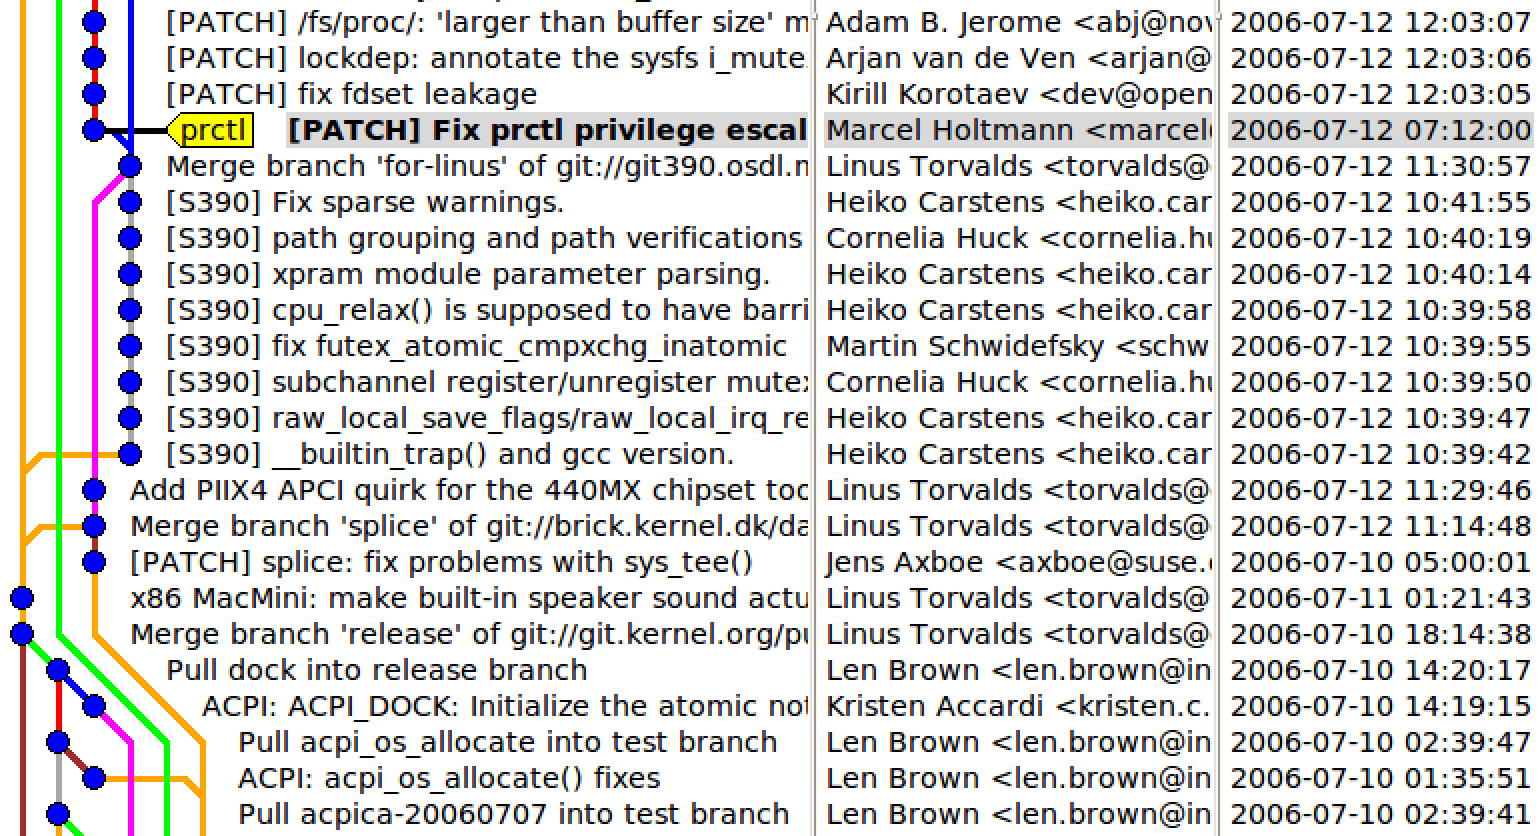
gitk (or github)

In [32]:
git diff $commit1 $commit2

git-diff         - Show changes between commits, commit and working tree, etc
diff --git a/README b/README
index 980a0d5..f25e220 100644
--- a/README
+++ b/README
@@ -1 +1 @@
-Hello World!
+New and improved.


<dl><dt>`git diff COMMIT1 COMMIT2 [-- PATH ...]`</dt><dd>show changes between two commits, restricted to changes under `PATH`</dd>
    <dt>`git diff --stat`</dt><dd>summarize changes, one line per file (useful with `log`)</dd>
    <dt>`git diff --word-diff`</dt><dd>show edits to individual words instead of lines</dd></dl>

Many other standard `diff` options (`-a`, `-b`, `-U5`, ...)

### What about renames?

Git doesn't know anything about renames... but it can guess

<dl><dt>`git diff -M[p]`</dt><dd>detect renames (as files at least *p*0% similar)</dd>
<dt>`git diff -C[p]`</dt><dd>detect copies as well</dd></dl>

## Commits by name: *refs* (branches...)
Finally, something that can change

Commits are static, immutable objects, so we need some way to represent the changing state of a repository.

In [33]:
git update-ref refs/heads/master $commit1
git show-ref

git-update-ref   - Update the object name stored in a ref safely
git-show-ref     - List references in a local repository
2efdb20ab8b7d2e585ae0cd4209f9c4c525d94e1 refs/heads/master


In [34]:
git update-ref refs/heads/master $commit2
cat .git/refs/heads/master

0b5bcf36d47bf5abc4ec35c72e9a2c0294d8d832


By convention (and because all the higher-level git commands expect it), branch names start with `refs/heads/` (which can thus be omitted), but can be any valid file name after that, like `dylan/refactor` or `release/2.x`.

In [35]:
git show master

commit 0b5bcf36d47bf5abc4ec35c72e9a2c0294d8d832 (HEAD -> master)
Author: Dylan Simon <dylan@dylex.net>
Date:   Thu Jun 22 15:00:00 2017

    Improve README with new stuff

diff --git a/README b/README
index 980a0d5..f25e220 100644
--- a/README
+++ b/README
@@ -1 +1 @@
-Hello World!
+New and improved.


In [36]:
git update-ref refs/heads/dylan/refactor master
git show-ref

0b5bcf36d47bf5abc4ec35c72e9a2c0294d8d832 refs/heads/dylan/refactor
0b5bcf36d47bf5abc4ec35c72e9a2c0294d8d832 refs/heads/master


### ... And tags

In [37]:
export GIT_COMMITTER_DATE="2017-06-27 11:00:00"

References can also represent tags, under `refs/tags/` by convention.  Unlike branch references, you usually don't move tags after they're created.

In [38]:
git tag -m "Presented at SciCon 2017-06-27" scicon17 master
git show-ref

git-tag          - Create, list, delete or verify a tag object signed with GPG
0b5bcf36d47bf5abc4ec35c72e9a2c0294d8d832 refs/heads/dylan/refactor
0b5bcf36d47bf5abc4ec35c72e9a2c0294d8d832 refs/heads/master
aa6742b68e7ea09070071d514e2030683f4ffd57 refs/tags/scicon17


Tags are also a type of object, the last kind we'll see, containing just a name, annotation (message), and commit hash.  Notice that refering references, like commits, is flexible, so you can leave off `refs/` and another part (`tags/`, `heads/`, or `remotes/`).

In [39]:
git cat-file -p tags/scicon17

object 0b5bcf36d47bf5abc4ec35c72e9a2c0294d8d832
type commit
tag scicon17
tagger Dylan Simon <dylan@dylex.net> 1498575600 -0400

Presented at SciCon 2017-06-27


*Revision*: any way to refer to a commit object (branch, tag, hash, `^`, ...)

## Isn't this wasteful?

In [40]:
echo $commit2 | git pack-objects --revs pack
ls -l pack-*

git-pack-objects - Create a packed archive of objects
Counting objects: 8, done.
Delta compression using up to 24 threads.
Compressing objects: 100% (5/5), done.
9c5a911abad74b62a7fefb630c71f6b30859a9dc
Writing objects: 100% (8/8), done.
Total 8 (delta 0), reused 0 (delta 0)
-r--r--r-- 1 dylan dylan 1296 Oct 16 14:20 pack-9c5a911abad74b62a7fefb630c71f6b30859a9dc.idx
-r--r--r-- 1 dylan dylan  661 Oct 16 14:20 pack-9c5a911abad74b62a7fefb630c71f6b30859a9dc.pack


In [41]:
rm -f pack-*

These packs are compressed, and yes this uses delta compression, meaning it is storing things like diffs.  However, it's important to remember that these diffs don't necessarily have anything to do with your commits, but are just based on efficient compression and file similarity.

#### Linux kernel:
   * raw source: 700MB
   * commits: 600k (since 2005)
   * git repo: 1.3GB
   
 "Don't worry about it."

### Caveat
git is designed for text files

Can handle any file in theory (github limit: 100MB), but poor for binary files

If you start putting GB-size binary data files in your git repo, you'll probably be unhappy. Things can get a little slow, but mainly remember that git will keep a copy of the object, doubling your disk usage.

Best practice is not to store generated content in git (and to add such files to `.gitignore` instead).

<div align='center'>
<h1>Part 2: Local Workflows</h1>
<h2>Convenient commit construction</h2>
</div>

You now know pretty much everything about how git actually works -- enough to be dangerous but not particularly useful. These commands can be rather impractical, so the rest is just higher-level ways of interacting with git more efficiently.

## Between filesystem and trees: *index* ("cache")
Moving files between git and your local *working tree* (disk)

The index, stored in `.git/index` as a mini object-store for a single tree (or a few), is a staging location between the files on disk and the main git object store.  Sometimes referred to as "cache" (in the more traditional sense of the word: a place to keep things, rather than the computer memory sense).

In [42]:
git read-tree $tree1
file .git/index
git ls-files

git-read-tree    - Reads tree information into the index
.git/index: Git index, version 2, 3 entries
git-ls-files     - Show information about files in the index and the working tree
README
stuff/hello.txt
stuff/other.txt


This copies an existing tree object into the index, whence we can get it to your working directory.

In [43]:
git checkout-index -a
ls -R

git-checkout-index - Copy files from the index to the working tree
.:
README  stuff

./stuff:
hello.txt  other.txt


Working with the index is one of the most important parts of day-to-day git.

### From files to index: *staging*
*Staging* changes to the index, from local changes made on disk

In [44]:
echo 'New and improved.' > README
git diff

diff --git a/README b/README
index 980a0d5..f25e220 100644
--- a/README
+++ b/README
@@ -1 +1 @@
-Hello World!
+New and improved.


In [45]:
git add README

git-add          - Add file contents to the index


`add` just updates the index to match whatever's on disk, for the files you give it.

In [46]:
git write-tree
echo $tree2

git-write-tree   - Create a tree object from the current index
674e727fabfeb840b5c4e36f2c33610dfb50458e
674e727fabfeb840b5c4e36f2c33610dfb50458e


Notice this is the same tree as the one we created earlier, because it has the same contents.

In [47]:
git rm stuff/other.txt
git ls-files

git-rm           - Remove files from the working tree and from the index
rm 'stuff/other.txt'
README
stuff/hello.txt


In [48]:
git mv README README.md
ls

git-mv           - Move or rename a file, a directory, or a symlink
README.md  stuff


#### quick reference: updating the index

<dl><dt>`git add -u [FILE|DIR] ...`</dt><dd>update *existing* index files from disk (update+remove entries)</dd>
<dt>`git add     FILE|DIR  ...`</dt><dd>update index files from disk (update+add entries)</dd>
<dt>`git add -A [FILE|DIR] ...`</dt><dd>update index to  match disk (update+add+remove entries)</dd>
<dt>`git add -p            ...`</dt><dd>*interactively* ask what to "stage" to index</dd>
<dt>`git mv SRC DST`</dt><dd>rename file/dir on disk and in index</dd>
<dt><code>git rm <font color='blue'>[-r]</font> <font color='red'>[-f]</font> FILE|DIR</code><dd>remove file <font color='blue'>(dir)</font> from disk and index <font color='red'>(even if local changes!)</font></dd>
<dt>`git rm --cached ...`</dt><dd>remove from index only (but not disk)</dd></dl>

### From index to files
*Checking out* the index to overwrite local changes

We saw above that `checkout-index` can copy files from the index to the disk, but there are also simpler options.

In [49]:
echo 'maybe not...' >> README.md
git diff

diff --git a/README.md b/README.md
index f25e220..63a9b90 100644
--- a/README.md
+++ b/README.md
@@ -1 +1,2 @@
 New and improved.
+maybe not...


In [50]:
git checkout -- README.md
git diff

git-checkout     - Switch branches or restore working tree files


#### quick reference: discarding changes

<dl><dt>`git checkout -- FILE|DIR ...`</dt><dd>overwrite files on disk from index</dd>
    <dt>`git checkout -p`</dt><dd>interactively ask what to "discard" from disk</dd>
</dl>

`checkout` does other things before the `--`

## Your current branch: *HEAD*

In [51]:
git symbolic-ref HEAD # show HEAD ref
cat .git/HEAD

git-symbolic-ref - Read, modify and delete symbolic refs
refs/heads/master
ref: refs/heads/master


A symbolic ref is a reference to another ref, kind of like a symbolic link or "pointer pointer".  `HEAD` is a pointer to the current branch (name).

In [52]:
git checkout dylan/refactor # also shows brief status of local 
git symbolic-ref HEAD
git branch

D	README
A	README.md
D	stuff/other.txt
Switched to branch 'dylan/refactor'
refs/heads/dylan/refactor
git-branch       - List, create, or delete branches
* dylan/refactor
  master


#### quick reference: branches

<dl><dt>`git checkout REV`</dt><dd>switch to a branch or "detached" revision (change HEAD)</dd>
<dt><code>git <font color='blue'>branch</font>      NEWBRANCH [REV]</code></dt>
<dt><code>git <font color='green'>checkout</font> <font color='blue'>-b</font> NEWBRANCH [REV]</code></dt><dd><font color='blue'>create</font> <font color='green'>(and switch to)</font> new branch at REV (`HEAD`)</dd>
<dt>`git checkout -m`</dt><dd>switch to branch and bring along un-committed changes on disk</dd>
<dt>`git checkout REV -- PATH ...`</dt><dd>overwrite files on disk from revision (but don't switch branches)</dd>
<dt>`git branch -va`</dt><dd>list all branches and latest commit</dd>
<dt>`git branch -m OLDBRANCH NEWBRANCH`</dt>
<dt>`git branch -d OLDBRANCH`</dt><dd>rename or delete branch</dd></dl>

## From index to HEAD: committing
Adding commits to your current branch from the index

In [53]:
export GIT_AUTHOR_DATE="2017-06-30T13:00:00"
export GIT_COMMITTER_DATE=$GIT_AUTHOR_DATE

In [54]:
git commit -m "Mark down 'README'; no more other.txt"

git-commit       - Record changes to the repository
[dylan/refactor e4212ad] Mark down 'README'; no more other.txt
 2 files changed, 1 deletion(-)
 rename README => README.md (100%)
 delete mode 100644 stuff/other.txt


In [55]:
git branch -va

* dylan/refactor e4212ad Mark down 'README'; no more other.txt
  master         0b5bcf3 Improve README with new stuff


In [56]:
git log --stat -2

commit e4212ad336cbaf2c4a5b454af07a484b1b09b83b (HEAD -> dylan/refactor)
Author: Dylan Simon <dylan@dylex.net>
Date:   Fri Jun 30 13:00:00 2017

    Mark down 'README'; no more other.txt

 README => README.md | 0
 stuff/other.txt     | 1 -
 2 files changed, 1 deletion(-)

commit 0b5bcf36d47bf5abc4ec35c72e9a2c0294d8d832 (tag: scicon17, master)
Author: Dylan Simon <dylan@dylex.net>
Date:   Thu Jun 22 15:00:00 2017

    Improve README with new stuff

 README | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


#### quick reference: commit

<dl>
    <dt>`git commit -a`</dt><dd>do `git add -u` and then commit (also `-p`)</dd>
    <dt><code>git commit -m MSG1 <font color='green'>[-m MSG2 ...]</font></code></dt><dd><font color='green'>(multi-paragraph)</font> commit message (instead of invoking editor)</dd>
    <dt>`git commit -v`</dt><dd>invoke editor and show full diff to write commit message</dd>
    <dt>`git commit -- PATH...`</dt><dd>commit all changes to files on disk <font color='red'>(bypass index)</font></dd></dl>

#### commit message guidelines

   * Use present tense in brief summary: "Fix crash with large N", "Cleanup temp files after run"
   * Include more details about motivation, results after summary
   * Address your future self

## Keeping track: status

In [57]:
echo "New stuff" > stuff/more.txt
git add stuff/more.txt
echo "More to read" >> README.md
git status # HEAD vs. index and index vs. disk

git-status       - Show the working tree status
On branch dylan/refactor
Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	new file:   stuff/more.txt

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   README.md



### One last diff quick reference

<dl><dt>`git diff   REV1..[REV2] [-- PATH ...]`</dt><dd>REV1 vs. REV2 (HEAD)</dd>
    <dt>`git diff                [-- PATH ...]`</dt><dd>disk vs. index</dd>
    <dt>`git diff           REV  [-- PATH ...]`</dt><dd>disk vs. REV</dd>
    <dt>`git diff --cached [REV] [-- PATH ...]`</dt><dd>index vs. REV (HEAD)</dd>
    </dl>

`git status` is one of the most useful commands you can just run all the time. The top part is the difference between your current HEAD and index (things you can commit); the bottom is the difference beetween your index and the disk (things you can add).

## (Un-)doing all the things: reset

In [58]:
git_helped[reset]=1

### Un-staging: undoing add, rm (repo to index)

<dl><dt>`git reset [REV] -- PATH ...`</dt><dd>sets the index file entries match those from revision (HEAD)</dd>
    <dt>`git reset -p`</dt><dd>ask interactively which changes to reset</dd></dl>
   
Dash-dash pattern: separates revisions from paths, can be omitted if unambiguous

In [59]:
git reset -- stuff/more.txt

Unstaged changes after reset:
M	README.md


### Index manipulation summary

<table style='font-size:100%'>
    <tr><th align='right'>↙</th><th>disk</th><th>index</th><th>repo</th></tr>
    <tr><th align='right'>disk</th><td bgcolor='black'></td><td colspan='2' align='left'>`checkout`</td></tr>
    <tr><th align='right'>index</th><td>`add`</td><td bgcolor='black'></td><td>`reset`</tr>
    <tr><th align='right'>repo</th><td colspan='2' align='center'>`commit`</td><td bgcolor='black'></td></tr>
</table>


### Un-comitting: changing which commit your branch points to

Changing where the current branch points

<dl><dt>`git reset --soft REV`</dt><dd>point the current branch to REV, but nothing else (same files on disk, index)</dd>
    <dt>`git reset --soft HEAD^`</dt><dd>undo the last `git commit` but keep my current changes, let my try again</dd>
    <dt>`git commit --amend`</dt><dd>replace the current commit with the index, keeping the commit message</dd>
    <dt>`git reset [--mixed] REV`</dt><dd>point current branch to REV, and also set index to match (but not disk)</dd>
    <dd>(If you want to keep your changes but re-add them on a different commit)</dd>
    <dt>`git reset --hard [REV]` </dt><dd>throw away everything (index+disk) and point current branch to REV</dd><dd>(HEAD: throw away all my work since last commit)</dd></dl>

<p>`reset` counts as <font color='red'>"<b>rewriting history</b>"</font> (like `rebase`): don't do this on branches shared with others</p>

This is different than `checkout` which just changes `HEAD` itself (no indirection).

There are other ways to rewrite history as well, specifically `git rebase`...

## Combining changes on commits/branches: merging

In [60]:
git status
git branch -va

On branch dylan/refactor
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   README.md

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	stuff/more.txt

no changes added to commit (use "git add" and/or "git commit -a")
* dylan/refactor e4212ad Mark down 'README'; no more other.txt
  master         0b5bcf3 Improve README with new stuff


In [61]:
git checkout -m master
git status

M	README
Switched to branch 'master'
On branch master
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   README

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	stuff/more.txt

no changes added to commit (use "git add" and/or "git commit -a")


In [62]:
git diff

diff --git a/README b/README
index f25e220..7074c76 100644
--- a/README
+++ b/README
@@ -1 +1,2 @@
 New and improved.
+More to read


In [63]:
export GIT_AUTHOR_DATE="2017-06-30T14:00:00"
export GIT_COMMITTER_DATE=$GIT_AUTHOR_DATE

In [64]:
git add .
git commit -m "Add more and more"

[master dc7e13a] Add more and more
 2 files changed, 2 insertions(+)
 create mode 100644 stuff/more.txt


In [65]:
git show-branch

git-show-branch  - Show branches and their commits
! [dylan/refactor] Mark down 'README'; no more other.txt
 * [master] Add more and more
--
 * [master] Add more and more
+  [dylan/refactor] Mark down 'README'; no more other.txt
+* [master^] Improve README with new stuff


In [66]:
git merge dylan/refactor

git-merge        - Join two or more development histories together
Removing stuff/other.txt
Merge made by the 'recursive' strategy.
 README => README.md | 0
 stuff/other.txt     | 1 -
 2 files changed, 1 deletion(-)
 rename README => README.md (100%)
 delete mode 100644 stuff/other.txt


In [67]:
git log --graph -4

*   commit f449e53c83fd0de9a94c36b271ce4a7c675ea92f (HEAD -> master)
|\  Merge: dc7e13a e4212ad
| | Author: Dylan Simon <dylan@dylex.net>
| | Date:   Fri Jun 30 14:00:00 2017
| | 
| |     Merge branch 'dylan/refactor'
| | 
| * commit e4212ad336cbaf2c4a5b454af07a484b1b09b83b (dylan/refactor)
| | Author: Dylan Simon <dylan@dylex.net>
| | Date:   Fri Jun 30 13:00:00 2017
| | 
| |     Mark down 'README'; no more other.txt
| | 
* | commit dc7e13a6ad09aca550d5179dcce8f82bc44255a9
|/  Author: Dylan Simon <dylan@dylex.net>
|   Date:   Fri Jun 30 14:00:00 2017
|   
|       Add more and more
| 
* commit 0b5bcf36d47bf5abc4ec35c72e9a2c0294d8d832 (tag: scicon17)
| Author: Dylan Simon <dylan@dylex.net>
| Date:   Thu Jun 22 15:00:00 2017
| 
|     Improve README with new stuff


### Dealing with merge conflicts

If the two branches cannot be combined cleanly (*conflicting* changes)...

   * Manually edit files with conflict markers and `git add` result
   * `git mergetool`: interactively resolve conflicts based on both sets of changes

## Commits derived from other commits
### Add a "reversed" commit: *revert*

In [68]:
git revert e4212ad

git-revert       - Revert some existing commits
[master 3fd3795] Revert "Mark down 'README'; no more other.txt"
 2 files changed, 1 insertion(+)
 rename README.md => README (100%)
 create mode 100644 stuff/other.txt


### Graft a "forward" commit: *cherry-pick*

If I wanted to un-revert that change, I could just `git revert` it again. Alternatively, I could re-apply the original commit, which is more common when wanting to take a few commits from someone else's branch, without merging the whole branch.

In [69]:
git cherry-pick e4212ad

git-cherry-pick  - Apply the changes introduced by some existing commits
[master 5482448] Mark down 'README'; no more other.txt
 Date: Fri Jun 30 13:00:00 2017 -0400
 2 files changed, 1 deletion(-)
 rename README => README.md (100%)
 delete mode 100644 stuff/other.txt


In [70]:
git log -2

commit 5482448f59a5f7ea2e488a9f1f077e5d0d3cfe37 (HEAD -> master)
Author: Dylan Simon <dylan@dylex.net>
Date:   Fri Jun 30 13:00:00 2017

    Mark down 'README'; no more other.txt

commit 3fd3795a58b28d39b4ae8b0cec8f70e26c6eaaf4
Author: Dylan Simon <dylan@dylex.net>
Date:   Fri Jun 30 14:00:00 2017

    Revert "Mark down 'README'; no more other.txt"
    
    This reverts commit e4212ad336cbaf2c4a5b454af07a484b1b09b83b.


### Convert a diff to a commit: *apply*

In [71]:
#git apply

## Wrapping things up: *clean*ing and *stash*ing

In [72]:
touch output.txt
git status

On branch master
Untracked files:
  (use "git add <file>..." to include in what will be committed)

	output.txt

nothing added to commit but untracked files present (use "git add" to track)


In [73]:
git clean -f

git-clean        - Remove untracked files from the working tree
Removing output.txt


In [74]:
echo "further reading" >> README.md
git status

On branch master
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   README.md

no changes added to commit (use "git add" and/or "git commit -a")


If you have some local chages, but you want to do something else for a minute (e.g., pull new changes, try something else, etc.), rather than copying your changes to a temp file, or creating a whole new branch (which is also perfectly reasonable, but a few extra steps), there is a stack of light-weight commits you can push and pop from.

In [75]:
git stash #push
git stash list

git-stash        - Stash the changes in a dirty working directory away
Saved working directory and index state WIP on master: 5482448 Mark down 'README'; no more other.txt
stash@{0}: WIP on master: 5482448 Mark down 'README'; no more other.txt


In [76]:
git stash pop

On branch master
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   README.md

no changes added to commit (use "git add" and/or "git commit -a")
Dropped refs/stash@{0} (2a4c13ea91689e4e2258ca24715088c9c52ef411)


## Rewriting history: *rebase*

   * `git rebase [COMMIT]`: attempt to linearize history (flatten merges) on top of COMMIT (upstream branch)
   * `git rebase -i [COMMIT]`: use a text editor to reorder or combine commits since COMMIT
   * Any rebased commits have different hashes -- git won't realize they're the same
   * Only rebase (or `reset`) unshared commits (or with agreement from everyone else)

Rebase is a powerful way of changing the shape or order of history (that is, the parents in the commit graph) while trying to preserve the same effects.  However, since it changes parents, it changes the resulting commit hashes, so the result will be incompatible with the un-rebased commits.


`git merge master`, then `git rebase master`

## Browsing history

In [77]:
cat README.md
git blame -- README.md

New and improved.
More to read
further reading
git-blame        - Show what revision and author last modified each line of a file
0b5bcf36 README    (Dylan Simon       2017-06-22 15:00:00 -0400 1) New and improved.
dc7e13a6 README    (Dylan Simon       2017-06-30 14:00:00 -0400 2) More to read
00000000 README.md (Not Committed Yet 2017-10-16 14:20:57 -0400 3) further reading


In [78]:
git checkout -- README.md

## Making git ignore files
Generated output, temporary files, etc.

In [79]:
echo '/output.*' > .gitignore
git add .gitignore
git commit -m 'Ignore all output files in top dir'
touch output.txt
git status

[master 7dfd4e5] Ignore all output files in top dir
 1 file changed, 1 insertion(+)
 create mode 100644 .gitignore
On branch master
nothing to commit, working tree clean


Ignore patterns:

  * `/*.out`: only in this directory
  * `*.out`: anywhere in this directory or below
  * `*.out/`: only directories (not files)
  * `!this.out`: cancel ignore

Ignore file lists:

  * `.gitignore`: in repository, for every instance of this repo
  * `~/.config/git/ignore`: for you only, in all your git repos
  * `.git/info/include`: for you only, in this repo

In [80]:
git clean -fx

Removing output.txt


<div align='center'>
<h1>Part 3: Remote Collaboration</h1>
<h2>Playing well with others</h2>
</div>

So far we've just talked about one git repository. The conceptual extention to moving data between multiple repositories is quite simple, but does involve a number of new commands.

## *remote* repositories

file path, sshable host (`[user@]host:/path`), or URL (`git:` or `https:`)

In [81]:
git remote add ghdylex git://github.com/dylex/git-structure-tutorial
git remote -v

git-remote       - Manage set of tracked repositories
ghdylex	git://github.com/dylex/git-structure-tutorial (fetch)
ghdylex	git://github.com/dylex/git-structure-tutorial (push)


Each repository has a set of "remotes", each associating a name with a URL.  Or really two URLs: one to *fetch* (download) and one to *push* (upload).

In [82]:
git fetch ghdylex # or: git remote update

git-fetch        - Download objects and refs from another repository
remote: Counting objects: 132, done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 132 (delta 58), reused 124 (delta 50), pack-reused 0
Receiving objects: 100% (132/132), 825.88 KiB | 15.02 MiB/s, done.
Resolving deltas: 100% (58/58), done.
From git://github.com/dylex/git-structure-tutorial
 * [new branch]      example    -> ghdylex/example
 * [new branch]      gh-pages   -> ghdylex/gh-pages
 * [new branch]      master     -> ghdylex/master


*fetch*: download each remote `refs/heads/BRANCH` to `refs/remotes/REMOTE/BRANCH` *tracking* branch

In [83]:
git branch -va

  dylan/refactor           e4212ad Mark down 'README'; no more other.txt
* master                   7dfd4e5 Ignore all output files in top dir
  remotes/ghdylex/example  f79c7b3 Add a period.
  remotes/ghdylex/gh-pages 2f5a17b Update generated slides from 2a6e7f1
  remotes/ghdylex/master   aca2903 More notes; include some understanding git slides


In [84]:
git merge ghdylex/example

Merge made by the 'recursive' strategy.
 README.md | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [85]:
git pull ghdylex example

git-pull         - Fetch from and integrate with another repository or a local branch
From git://github.com/dylex/git-structure-tutorial
 * branch            example    -> FETCH_HEAD
Already up-to-date.


`git fetch ; git merge` is such a common workflow that one command can do both

### Uploading: *push*

In [86]:
! git push ghdylex master

git-push         - Update remote refs along with associated objects
fatal: remote error: 
  You can't push to git://github.com/dylex/git-structure-tutorial.git
  Use https://github.com/dylex/git-structure-tutorial.git


#### quick reference: remote send/receive
<dl><dt>`git fetch -p`, `--prune`</dt><dd>also delete `refs/remotes/*` missing on remote</dd>
<dt>`git push REMOTE [SRCREF:]BRANCH`</dt><dd>update the remote `refs/heads/BRANCH` to `SRCREF`</dd>
<dt>`git push -u ...`</dt><dd>set the default for *pull* and *push* on current branch (see config)</dd>
<dt>`git checkout|branch -t BRANCH`</dt><dd>set default *pull* tracking source (default for *checkout* when no local branch)</dd>
<dt>`git push --force ...`</dt><dd>like remote *reset*, can remove commits (<font color='red'>don't do this!</font> why not?)</dd>
<dt>`git push REMOTE :BRANCH`</dt><dd>delete remote branch</dd></dl>

Unlike branches, tags (even though they are both just references) are assumed to be immutable, so `fetch --tags` just puts them under `refs/tags`, not `refs/remotes`.

In [87]:
git log --graph

*   commit 7098d57271ab38aea12fa2381b85e91c29f98789 (HEAD -> master)
|\  Merge: 7dfd4e5 f79c7b3
| | Author: Dylan Simon <dylan@dylex.net>
| | Date:   Fri Jun 30 14:00:00 2017
| | 
| |     Merge remote-tracking branch 'ghdylex/example'
| | 
| * commit f79c7b3fbb14f1664adeec9e5a6a36b023b5c171 (ghdylex/example)
| | Author: Dylan Simon <dylan@dylex.net>
| | Date:   Mon Oct 16 14:13:31 2017
| | 
| |     Add a period.
| | 
* | commit 7dfd4e5f1c0d4aaf481326f5f3edbb008bcabf12
|/  Author: Dylan Simon <dylan@dylex.net>
|   Date:   Fri Jun 30 14:00:00 2017
|   
|       Ignore all output files in top dir
| 
* commit 5482448f59a5f7ea2e488a9f1f077e5d0d3cfe37
| Author: Dylan Simon <dylan@dylex.net>
| Date:   Fri Jun 30 13:00:00 2017
| 
|     Mark down 'README'; no more other.txt
| 
* commit 3fd3795a58b28d39b4ae8b0cec8f70e26c6eaaf4
| Author: Dylan Simon <dylan@dylex.net>
| Date:   Fri Jun 30 14:00:00 2017
| 
|     Revert "Mark down 'README'; no more other.txt"
|     
|     This reverts commit e4212ad3

## Back to the beginning: *clone*

In [88]:
git clone git://github.com/dylex/git-structure-tutorial

git-clone        - Clone a repository into a new directory
Cloning into 'git-structure-tutorial'...
remote: Counting objects: 153, done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 153 (delta 29), reused 60 (delta 23), pack-reused 85
Receiving objects: 100% (153/153), 981.59 KiB | 18.52 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [89]:
git -C git-structure-tutorial branch -va

* master                  aca2903 More notes; include some understanding git slides
  remotes/origin/HEAD     -> origin/master
  remotes/origin/example  f79c7b3 Add a period.
  remotes/origin/gh-pages 2f5a17b Update generated slides from 2a6e7f1
  remotes/origin/master   aca2903 More notes; include some understanding git slides


clone is equivalent to:
* `git init DIR` (default to repo basename, set with `git clone URL DIR`)
* `git remote add origin URL` (`-o REMOTE` sets name)
* `git fetch REMOTE`
* `git checkout master` (`-b BRANCH` sets branch) or `git checkout -b BRANCH -t REMOTE/BRANCH`

## Practical workflow
* `git pull`
* edit edit, `git status`, edit edit
* `git commit -a`
* `git push`
* repeat

# Future topics

* github
   * [github.com/flatironinstitute](https://github.com/flatironinstitute) (contact SCC to join)
   * gh-pages (user/repo `gh-pages` branch published as user.github.io/repo)
   * issues, pull requests, workflows
   * permissions
   * web hooks
* branching/tagging strategies
* code structure
* documentation
* continuous integration

[Nelson Elhage & Anders Kaseorg's *Understanding Git*](http://web.mit.edu/nelhage/Public/git-slides-2009.pdf)

In [90]:
git help core-tutorial

GITCORE-TUTORIAL(7)               Git Manual               GITCORE-TUTORIAL(7)

NAME
       gitcore-tutorial - A Git core tutorial for developers

SYNOPSIS
       git *

DESCRIPTION
       This tutorial explains how to use the "core" Git commands to set up and
       work with a Git repository.

       If you just need to use Git as a revision control system you may prefer
       to start with "A Tutorial Introduction to Git" (gittutorial(7)) or the
       Git User Manual[1].

       However, an understanding of these low-level tools can be helpful if
       you want to understand Git’s internals.

       The core Git is often called "plumbing", with the prettier user
       interfaces on top of it called "porcelain". You may not want to use the
       plumbing directly very often, but it can be good to know what the
       plumbing does when the porcelain isn’t flushing.

       Back when this document was originally written, many porcelain commands
       were shell scripts. For simp

           name to only the first several hexadecimal digits in most places.

       Anyway, as we mentioned previously, you normally never actually take a
       look at the objects themselves, and typing long 40-character hex names
       is not something you’d normally want to do. The above digression was
       just to show that git update-index did something magical, and actually
       saved away the contents of your files into the Git object database.

       Updating the index did something else too: it created a .git/index
       file. This is the index that describes your current working tree, and
       something you should be very aware of. Again, you normally never worry
       about the index file itself, but you should be aware of the fact that
       you have not actually really "checked in" your files into Git so far,
       you’ve only told Git about them.

       However, since Git knows about them, you can now start using some of
       the most basic Git commands t

       set of differences, and that’s exactly what it does.

           Note
           git diff-index really always uses the index for its comparisons,
           and saying that it compares a tree against the working tree is thus
           not strictly accurate. In particular, the list of files to compare
           (the "meta-data") always comes from the index file, regardless of
           whether the --cached flag is used or not. The --cached flag really
           only determines whether the file contents to be compared come from
           the working tree or not.

           This is not hard to understand, as soon as you realize that Git
           simply never knows (or cares) about files that it is not told about
           explicitly. Git will never go looking for files to compare, it
           expects you to tell it what the files are, and that’s what the
           index is there for.

       However, our next step is to commit the change we did, and again, to
       und

           You can tell Git to split the Git internal information from the
           directory that it tracks, but we’ll ignore that for now: it’s not
           how normal projects work, and it’s really only meant for special
           uses. So the mental model of "the Git information is always tied
           directly to the working tree that it describes" may not be
           technically 100% accurate, but it’s a good model for all normal
           use.

       This has two implications:

       ·   if you grow bored with the tutorial repository you created (or
           you’ve made a mistake and want to start all over), you can just do
           simple

               $ rm -rf git-tutorial

           and it will be gone. There’s no external repository, and there’s no
           history outside the project you created.

       ·   if you want to move or duplicate a Git repository, you can do so.
           There is git clone command, but if all you want to do is just to
     

       filename directly to git commit, with an -i flag (it tells Git to
       include that file in addition to what you have done to the index file
       so far when making the commit). The -m flag is to give the commit log
       message from the command line.

       Now, to make it a bit more interesting, let’s assume that somebody else
       does some work in the original branch, and simulate that by going back
       to the master branch, and editing the same file differently there:

           $ git checkout master

       Here, take a moment to look at the contents of hello, and notice how
       they don’t contain the work we just did in mybranch — because that work
       hasn’t happened in the master branch at all. Then do

           $ echo "Play, play, play" >>hello
           $ echo "Lots of fun" >>example
           $ git commit -m "Some fun." -i hello example

       since the master branch is obviously in a much better mood.

       Now, you’ve got two branches, and

           minimum set of objects. It is by far the most efficient way to
           exchange Git objects between repositories.

       Local directory
           /path/to/repo.git/

           This transport is the same as SSH transport but uses sh to run both
           ends on the local machine instead of running other end on the
           remote machine via ssh.

       Git Native
           git://remote.machine/path/to/repo.git/

           This transport was designed for anonymous downloading. Like SSH
           transport, it finds out the set of objects the downstream side
           lacks and transfers (close to) minimum set of objects.

       HTTP(S)
           http://remote.machine/path/to/repo.git/

           Downloader from http and https URL first obtains the topmost commit
           object name from the remote site by looking at the specified
           refname under repo.git/refs/ directory, and then tries to obtain
           the commit object by downloading from r

       result with conflict marks is left in the working tree.. This can be
       seen if you run ls-files --stage again at this point:

           $ git ls-files --stage
           100644 7f8b141b65fdcee47321e399a2598a235a032422 0       example
           100644 557db03de997c86a4a028e1ebd3a1ceb225be238 1       hello
           100644 ba42a2a96e3027f3333e13ede4ccf4498c3ae942 2       hello
           100644 cc44c73eb783565da5831b4d820c962954019b69 3       hello

       This is the state of the index file and the working file after git
       merge returns control back to you, leaving the conflicting merge for
       you to resolve. Notice that the path hello is still unmerged, and what
       you see with git diff at this point is differences since stage 2 (i.e.
       your version).

PUBLISHING YOUR WORK
       So, we can use somebody else’s work from a remote repository, but how
       can you prepare a repository to let other people pull from it?

       You do your real work in you


        1. Prepare your primary repository on your local machine. Your work is
           done there.

        2. Prepare a public repository accessible to others.

           If other people are pulling from your repository over dumb
           transport protocols (HTTP), you need to keep this repository dumb
           transport friendly. After git init,
           $GIT_DIR/hooks/post-update.sample copied from the standard
           templates would contain a call to git update-server-info but you
           need to manually enable the hook with mv post-update.sample
           post-update. This makes sure git update-server-info keeps the
           necessary files up-to-date.

        3. Push into the public repository from your primary repository.

        4. git repack the public repository. This establishes a big pack that
           contains the initial set of objects as the baseline, and possibly
           git prune if the transport used for pulling from your repository
     

       a valid thing to do and often makes it easier to view the commit
       history if you are merging more than two independent changes at the
       same time. However, if you have merge conflicts with any of the
       branches you are merging in and need to hand resolve, that is an
       indication that the development happened in those branches were not
       independent after all, and you should merge two at a time, documenting
       how you resolved the conflicts, and the reason why you preferred
       changes made in one side over the other. Otherwise it would make the
       project history harder to follow, not easier.

SEE ALSO
       gittutorial(7), gittutorial-2(7), gitcvs-migration(7), git-help(1),
       giteveryday(7), The Git User’s Manual[1]

GIT
       Part of the git(1) suite

NOTES
        1. the Git User Manual
           git-htmldocs/user-manual.html

        2. Randy Dunlap’s presentation
           https://web.archive.org/web/20120915203609/http://www.xe

In [91]:
git help glossary

GITGLOSSARY(7)                    Git Manual                    GITGLOSSARY(7)

NAME
       gitglossary - A Git Glossary

SYNOPSIS
       *

DESCRIPTION
       alternate object database
           Via the alternates mechanism, a repository can inherit part of its
           object database from another object database, which is called an
           "alternate".

       bare repository
           A bare repository is normally an appropriately named directory with
           a .git suffix that does not have a locally checked-out copy of any
           of the files under revision control. That is, all of the Git
           administrative and control files that would normally be present in
           the hidden .git sub-directory are directly present in the
           repository.git directory instead, and no other files are present
           and checked out. Usually publishers of public repositories make
           bare repositories available.

       blob object
           Untyped object

           derived from the state of the tree referred to by HEAD. HEAD is a
           reference to one of the heads in your repository, except when using
           a detached HEAD, in which case it directly references an arbitrary
           commit.

       head ref
           A synonym for head.

       hook
           During the normal execution of several Git commands, call-outs are
           made to optional scripts that allow a developer to add
           functionality or checking. Typically, the hooks allow for a command
           to be pre-verified and potentially aborted, and allow for a
           post-notification after the operation is done. The hook scripts are
           found in the $GIT_DIR/hooks/ directory, and are enabled by simply
           removing the .sample suffix from the filename. In earlier versions
           of Git you had to make them executable.

       index
           A collection of files with stat information, whose contents are
           stored 

                   matches "a/b", "a/x/b", "a/x/y/b" and so on.

               ·   Other consecutive asterisks are considered invalid.

                   Glob magic is incompatible with literal magic.

           attr
               After attr: comes a space separated list of "attribute
               requirements", all of which must be met in order for the path
               to be considered a match; this is in addition to the usual
               non-magic pathspec pattern matching. See gitattributes(5).

               Each of the attribute requirements for the path takes one of
               these forms:

               ·   "ATTR" requires that the attribute ATTR be set.

               ·   "-ATTR" requires that the attribute ATTR be unset.

               ·   "ATTR=VALUE" requires that the attribute ATTR be set to the
                   string VALUE.

               ·   "!ATTR" requires that the attribute ATTR be unspecified.

           exclude
               After a path mat

           submodules.

       symref
           Symbolic reference: instead of containing the SHA-1 id itself, it
           is of the format ref: refs/some/thing and when referenced, it
           recursively dereferences to this reference.  HEAD is a prime
           example of a symref. Symbolic references are manipulated with the
           git-symbolic-ref(1) command.

       tag
           A ref under refs/tags/ namespace that points to an object of an
           arbitrary type (typically a tag points to either a tag or a commit
           object). In contrast to a head, a tag is not updated by the commit
           command. A Git tag has nothing to do with a Lisp tag (which would
           be called an object type in Git’s context). A tag is most typically
           used to mark a particular point in the commit ancestry chain.

       tag object
           An object containing a ref pointing to another object, which can
           contain a message just like a commit object. 